In [1]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from tqdm.notebook import tqdm
from keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

In [2]:
# disable progress bars when submitting
def is_interactive():
   return 'SHLVL' not in os.environ

if not is_interactive():
    def nop(it, *a, **k):
        return it

    tqdm = nop

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# Preprocessing

读入文本并进行预处理

In [3]:
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 220

In [4]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [5]:
max_features = None

train = pd.read_csv('../dataset/train.csv')
# test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

x_train = preprocess(train['comment_text'])
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]

In [7]:
# 均衡化数据集
# 确定数量较少的类别
count_class_0 = np.sum(y_train == 0)
count_class_1 = np.sum(y_train == 1)

# 从数量较多的类别中随机抽样
index_class_0 = np.where(y_train == 0)[0]
index_class_1 = np.where(y_train == 1)[0]

# 从数量较多的类别中随机选择与数量较少的类别相同数量的样本
seed_everything()
selected_index_class_0 = np.random.choice(index_class_0, count_class_1, replace=False)

# 构建平衡的数据集
x_train = np.concatenate([x_train[selected_index_class_0], x_train[index_class_1]])
y_train = np.concatenate([y_train[selected_index_class_0], y_train[index_class_1]])
y_aux_train = np.concatenate([y_aux_train.iloc[selected_index_class_0], y_aux_train.iloc[index_class_1]])


In [8]:
# 划分训练集和测试集，按照9:1的比例
x_train, x_test, y_train, y_test, y_aux_train, y_aux_test = train_test_split(
    x_train, y_train, y_aux_train, test_size=0.1, random_state=1624)

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = pad_sequences(x_train, maxlen=MAX_LEN)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)

max_features = max_features or len(tokenizer.word_index) + 1
max_features

122578

In [9]:
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
y_train_torch = torch.tensor(np.hstack([y_train[:, np.newaxis], y_aux_train]), dtype=torch.float32).cuda()
y_train_baseline = torch.tensor(y_train, dtype=torch.float32).cuda()

读入对应的预训练embedding

In [10]:
CRAWL_EMBEDDING_PATH = '../WordEmbedding/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '../WordEmbedding/glove.840B.300d.txt'

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [11]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (crawl):  38008
n unknown words (glove):  36611


In [12]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

del crawl_matrix
del glove_matrix
gc.collect()

0

# Model

In [13]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

# Training

In [14]:
import matplotlib.pyplot as plt
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def train_model(model, train, test, loss_fn, output_dim, lr=0.005,
                batch_size=512, n_epochs=30,
                enable_checkpoint_ensemble=True):
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    all_test_preds = []
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    
    train_losses = []
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        scheduler.step()
        
        model.train()
        avg_loss = 0.
        
        for data in tqdm(train_loader, disable=False):
            x_batch = data[:-1]
            y_batch = data[-1]

            y_pred = model(*x_batch)            
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            train_losses.append(loss.item())
            
        model.eval()
        test_preds = np.zeros((len(test), output_dim))
    
        for i, x_batch in enumerate(test_loader):
            y_pred = sigmoid(model(*x_batch).detach().cpu().numpy())

            test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred

        all_test_preds.append(test_preds)
        elapsed_time = time.time() - start_time
        print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
              epoch + 1, n_epochs, avg_loss, elapsed_time))

    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        test_preds = all_test_preds[-1]
     # Plot the training loss curve
    plt.plot(train_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()
        
    return test_preds[:,0],model

Model  0
Epoch 1/30 	 loss=0.2430 	 time=17.12s
Epoch 2/30 	 loss=0.2238 	 time=17.29s
Epoch 3/30 	 loss=0.2194 	 time=17.49s
Epoch 4/30 	 loss=0.2160 	 time=17.13s
Epoch 5/30 	 loss=0.2133 	 time=17.59s
Epoch 6/30 	 loss=0.2110 	 time=17.16s
Epoch 7/30 	 loss=0.2087 	 time=17.51s
Epoch 8/30 	 loss=0.2068 	 time=17.18s
Epoch 9/30 	 loss=0.2050 	 time=17.51s
Epoch 10/30 	 loss=0.2032 	 time=17.48s
Epoch 11/30 	 loss=0.2020 	 time=17.44s
Epoch 12/30 	 loss=0.2004 	 time=17.64s
Epoch 13/30 	 loss=0.1989 	 time=17.56s
Epoch 14/30 	 loss=0.1975 	 time=17.29s
Epoch 15/30 	 loss=0.1965 	 time=17.56s
Epoch 16/30 	 loss=0.1954 	 time=17.26s
Epoch 17/30 	 loss=0.1942 	 time=17.68s
Epoch 18/30 	 loss=0.1933 	 time=17.56s
Epoch 19/30 	 loss=0.1922 	 time=17.31s
Epoch 20/30 	 loss=0.1914 	 time=17.55s
Epoch 21/30 	 loss=0.1903 	 time=17.28s
Epoch 22/30 	 loss=0.1895 	 time=17.50s
Epoch 23/30 	 loss=0.1888 	 time=17.30s
Epoch 24/30 	 loss=0.1880 	 time=17.56s
Epoch 25/30 	 loss=0.1873 	 time=17.56s


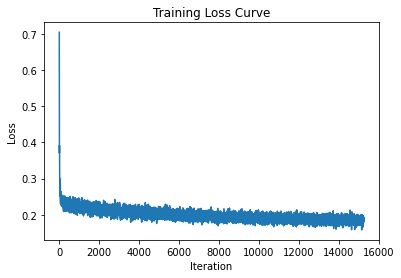


Model  1
Epoch 1/30 	 loss=0.2439 	 time=17.54s
Epoch 2/30 	 loss=0.2238 	 time=17.21s
Epoch 3/30 	 loss=0.2190 	 time=17.44s
Epoch 4/30 	 loss=0.2159 	 time=17.19s
Epoch 5/30 	 loss=0.2132 	 time=17.46s
Epoch 6/30 	 loss=0.2109 	 time=17.46s
Epoch 7/30 	 loss=0.2087 	 time=17.30s
Epoch 8/30 	 loss=0.2067 	 time=17.46s
Epoch 9/30 	 loss=0.2049 	 time=17.44s
Epoch 10/30 	 loss=0.2032 	 time=17.18s
Epoch 11/30 	 loss=0.2019 	 time=17.48s
Epoch 12/30 	 loss=0.2001 	 time=17.21s
Epoch 13/30 	 loss=0.1988 	 time=17.51s
Epoch 14/30 	 loss=0.1977 	 time=17.48s
Epoch 15/30 	 loss=0.1963 	 time=17.24s
Epoch 16/30 	 loss=0.1951 	 time=17.57s
Epoch 17/30 	 loss=0.1939 	 time=17.23s
Epoch 18/30 	 loss=0.1929 	 time=17.48s
Epoch 19/30 	 loss=0.1920 	 time=17.25s
Epoch 20/30 	 loss=0.1911 	 time=17.51s
Epoch 21/30 	 loss=0.1903 	 time=17.67s
Epoch 22/30 	 loss=0.1894 	 time=17.22s
Epoch 23/30 	 loss=0.1886 	 time=17.47s
Epoch 24/30 	 loss=0.1878 	 time=17.51s
Epoch 25/30 	 loss=0.1872 	 time=17.25s

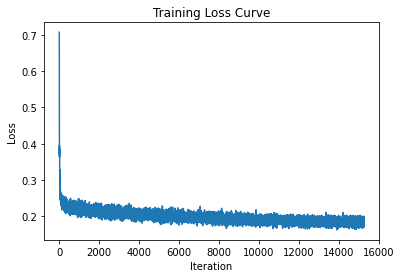

In [27]:
train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
test_dataset = data.TensorDataset(x_test_torch)

all_test_preds = []

for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(1234 + model_idx)
    
    model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
    model.cuda()
    
    test_preds,model = train_model(model, train_dataset, test_dataset, output_dim=y_train_torch.shape[-1], 
                             loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))
    torch.save(model.state_dict(), f'model{model_idx}.pth')
    all_test_preds.append(test_preds)
    print()

In [28]:
from sklearn.metrics import confusion_matrix
for model_idx in range(NUM_MODELS):
    preds = np.where(all_test_preds[model_idx]>0.5,1,0)
    cm = confusion_matrix(y_test, preds)
    # 输出混淆矩阵
    print(f"Confusion Matrix of Model {model_idx}:")
    print(cm)
    print(f'acc of model{model_idx} = ',np.sum(preds==y_test)/preds.shape[0])

ensemble_preds = np.zeros(y_test.shape)
for model_idx in range(NUM_MODELS):
    ensemble_preds += all_test_preds[model_idx]
ensemble_preds /= NUM_MODELS

cm = confusion_matrix(y_test, np.where(ensemble_preds>0.5,1,0))
# 输出混淆矩阵
print(f"Confusion Matrix of Ensemble Model:")
print(cm)
print(f'acc of ensemble model = ',np.sum(np.where(ensemble_preds>0.5,1,0)==y_test)/preds.shape[0])



Confusion Matrix of Model 0:
[[12652  1850]
 [ 1259 13106]]
acc of model0 =  0.8922991651366612
Confusion Matrix of Model 1:
[[12654  1848]
 [ 1170 13195]]
acc of model1 =  0.8954515536772093
Confusion Matrix of Ensemble Model:
[[12733  1769]
 [ 1082 13283]]
acc of ensemble model =  0.9012367062735996


这个地方20个epoch的效果也跟这里差不多了，但是训练集loss会更低一些，可能可以再训练训练。

# Non-Multi-task

In [22]:
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden).squeeze()
        
        return result

In [24]:
def train_model(model, train, test, loss_fn, output_dim, lr=0.005,
                batch_size=512, n_epochs=30,
                enable_checkpoint_ensemble=True):
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    all_test_preds = []
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    
    train_losses = []
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        scheduler.step()
        
        model.train()
        avg_loss = 0.
        
        for data in tqdm(train_loader, disable=False):
            x_batch = data[:-1]
            y_batch = data[-1]

            y_pred = model(*x_batch)            
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            train_losses.append(loss.item())
            
        model.eval()
        test_preds = np.zeros(len(test))
    
        for i, x_batch in enumerate(test_loader):
            y_pred = sigmoid(model(*x_batch).detach().cpu().numpy())

            test_preds[i * batch_size:(i+1) * batch_size] = y_pred

        all_test_preds.append(test_preds)
        elapsed_time = time.time() - start_time
        print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
              epoch + 1, n_epochs, avg_loss, elapsed_time))

    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        test_preds = all_test_preds[-1]
     # Plot the training loss curve
    plt.plot(train_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()
        
    return test_preds,model

Model  0
Epoch 1/30 	 loss=0.3025 	 time=17.50s
Epoch 2/30 	 loss=0.2484 	 time=17.18s
Epoch 3/30 	 loss=0.2309 	 time=17.38s
Epoch 4/30 	 loss=0.2178 	 time=17.71s
Epoch 5/30 	 loss=0.2047 	 time=17.32s
Epoch 6/30 	 loss=0.1939 	 time=17.66s
Epoch 7/30 	 loss=0.1816 	 time=17.57s
Epoch 8/30 	 loss=0.1726 	 time=17.69s
Epoch 9/30 	 loss=0.1625 	 time=17.38s
Epoch 10/30 	 loss=0.1523 	 time=17.64s
Epoch 11/30 	 loss=0.1444 	 time=17.59s
Epoch 12/30 	 loss=0.1363 	 time=17.41s
Epoch 13/30 	 loss=0.1284 	 time=17.62s
Epoch 14/30 	 loss=0.1217 	 time=17.74s
Epoch 15/30 	 loss=0.1152 	 time=17.40s
Epoch 16/30 	 loss=0.1071 	 time=17.64s
Epoch 17/30 	 loss=0.1028 	 time=17.50s
Epoch 18/30 	 loss=0.0970 	 time=17.32s
Epoch 19/30 	 loss=0.0911 	 time=17.50s
Epoch 20/30 	 loss=0.0864 	 time=17.62s
Epoch 21/30 	 loss=0.0820 	 time=17.29s
Epoch 22/30 	 loss=0.0789 	 time=17.52s
Epoch 23/30 	 loss=0.0749 	 time=17.54s
Epoch 24/30 	 loss=0.0711 	 time=17.32s
Epoch 25/30 	 loss=0.0674 	 time=17.57s


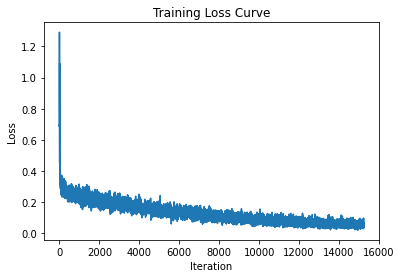


Model  1
Epoch 1/30 	 loss=0.2944 	 time=17.34s
Epoch 2/30 	 loss=0.2478 	 time=17.44s
Epoch 3/30 	 loss=0.2308 	 time=17.25s
Epoch 4/30 	 loss=0.2166 	 time=17.54s
Epoch 5/30 	 loss=0.2047 	 time=17.51s
Epoch 6/30 	 loss=0.1926 	 time=17.41s
Epoch 7/30 	 loss=0.1814 	 time=17.48s
Epoch 8/30 	 loss=0.1714 	 time=17.54s
Epoch 9/30 	 loss=0.1615 	 time=17.28s
Epoch 10/30 	 loss=0.1531 	 time=17.65s
Epoch 11/30 	 loss=0.1450 	 time=17.54s
Epoch 12/30 	 loss=0.1366 	 time=17.36s
Epoch 13/30 	 loss=0.1295 	 time=17.51s
Epoch 14/30 	 loss=0.1228 	 time=17.54s
Epoch 15/30 	 loss=0.1149 	 time=17.31s
Epoch 16/30 	 loss=0.1095 	 time=17.58s
Epoch 17/30 	 loss=0.1035 	 time=17.54s
Epoch 18/30 	 loss=0.0983 	 time=17.45s
Epoch 19/30 	 loss=0.0932 	 time=17.49s
Epoch 20/30 	 loss=0.0883 	 time=17.54s
Epoch 21/30 	 loss=0.0834 	 time=17.29s
Epoch 22/30 	 loss=0.0806 	 time=17.67s
Epoch 23/30 	 loss=0.0749 	 time=17.57s
Epoch 24/30 	 loss=0.0724 	 time=17.33s
Epoch 25/30 	 loss=0.0698 	 time=17.50s

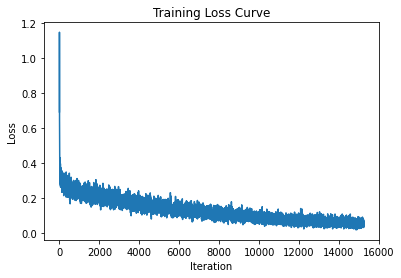

In [25]:
train_dataset = data.TensorDataset(x_train_torch, y_train_baseline)
test_dataset = data.TensorDataset(x_test_torch)

all_test_preds = []

for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(1234 + model_idx)
    
    model = NeuralNet(embedding_matrix)
    model.cuda()
    
    test_preds,model = train_model(model, train_dataset, test_dataset, output_dim=y_train_baseline.shape[-1], 
                             loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))
    torch.save(model.state_dict(), f'Baseline model{model_idx}.pth')
    all_test_preds.append(test_preds)
    print()

In [26]:
from sklearn.metrics import confusion_matrix
for model_idx in range(NUM_MODELS):
    preds = np.where(all_test_preds[model_idx]>0.5,1,0)
    cm = confusion_matrix(y_test, preds)
    # 输出混淆矩阵
    print(f"Confusion Matrix of Model {model_idx}:")
    print(cm)
    print(f'acc of model{model_idx} = ',np.sum(preds==y_test)/preds.shape[0])

ensemble_preds = np.zeros(y_test.shape)
for model_idx in range(NUM_MODELS):
    ensemble_preds += all_test_preds[model_idx]
ensemble_preds /= NUM_MODELS

cm = confusion_matrix(y_test, np.where(ensemble_preds>0.5,1,0))
# 输出混淆矩阵
print(f"Confusion Matrix of Ensemble Model:")
print(cm)
print(f'acc of ensemble model = ',np.sum(np.where(ensemble_preds>0.5,1,0)==y_test)/preds.shape[0])



Confusion Matrix of Model 0:
[[12537  1965]
 [ 1293 13072]]
acc of model0 =  0.8871375619219177
Confusion Matrix of Model 1:
[[12743  1759]
 [ 1481 12884]]
acc of model1 =  0.8877611113035646
Confusion Matrix of Ensemble Model:
[[12722  1780]
 [ 1224 13141]]
acc of ensemble model =  0.8959365365296013


虽然在训练集上，non-multitask的loss小得多，下降的也快，但是我们可以发现，它在测试集上的表现不如multitask。

这验证了multi-task的有效性。